# Peramalan Harga Penutupan Saham BMRI dengan Mempertimbangkan Pengaruh Makroekonomi menggunakan Model Hybrid LSTM-Transformer

* Dicoding ID: MC008D5Y1552
* Email: kurniawanchandrawi@gmail.com

---

Import *package* dan *setup environment* terlebih dahulu:

In [9]:
import os
os.chdir('..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from src.data_loader import load_and_merge_all
from src.data_preparation import preprocess_data
from src.models import build_lstm_multi_input, build_lstm_transformer, build_lstm_transformer_tcn
from src.train import train_model
from src.evaluate import evaluate_forecast

from src.utils import create_sequences, inverse_transform, multi_step_forecast
from src.visualization import plot_train_val_forecast

from sklearn.preprocessing import RobustScaler

In [17]:
import pandas as pd

## Load & Preprocess Data

In [ ]:
raw_data = load_and_merge_all()
print("Data mentah gabungan:")
print(raw_data.head())

processed_data = preprocess_data(raw_data)
print("\nData setelah preprocessing:")
print(processed_data.head())

Data mentah gabungan:
        Date  BMRI.JK.Adjusted  JKSE.Adjusted Data Inflasi BI-7Day-RR  \
0 2020-01-02       2800.025879    6283.581055          NaN        NaN   
1 2020-01-03       2790.993408    6323.465820          NaN        NaN   
2 2020-01-06       2745.831543    6257.402832          NaN        NaN   
3 2020-01-07       2745.831543    6279.346191          NaN        NaN   
4 2020-01-08       2709.702148    6225.686035          NaN        NaN   

      Price  
0  13,889.0  
1  13,925.0  
2  13,940.0  
3  13,875.0  
4  13,892.5  

Data setelah preprocessing:
        Date         BMRI         IHSG  Inflasi  Bunga     Kurs
0 2020-01-02  2800.025879  6283.581055   0.0267   0.05  13889.0
1 2020-01-03  2790.993408  6323.465820   0.0267   0.05  13925.0
2 2020-01-04  2775.939453  6301.444824   0.0267   0.05  13930.0
3 2020-01-05  2760.885498  6279.423828   0.0267   0.05  13935.0
4 2020-01-06  2745.831543  6257.402832   0.0267   0.05  13940.0


Data telah diproses sedemikian hingga siap untuk dilakukan analisis.

## Data Understanding

In [10]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1942 entries, 5 to 1946
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1942 non-null   datetime64[ns]
 1   BMRI          1942 non-null   float64       
 2   IHSG          1942 non-null   float64       
 3   Inflasi       1942 non-null   float64       
 4   Bunga         1942 non-null   float64       
 5   Kurs          1942 non-null   float64       
 6   IHSG_lag1     1942 non-null   float64       
 7   IHSG_lag2     1942 non-null   float64       
 8   IHSG_lag3     1942 non-null   float64       
 9   IHSG_lag4     1942 non-null   float64       
 10  IHSG_lag5     1942 non-null   float64       
 11  Inflasi_lag1  1942 non-null   float64       
 12  Inflasi_lag2  1942 non-null   float64       
 13  Inflasi_lag3  1942 non-null   float64       
 14  Inflasi_lag4  1942 non-null   float64       
 15  Inflasi_lag5  1942 non-null   float64      

Data terdiri atas 1.942 baris dan 25 kolom.

In [11]:
display(processed_data.head(1), processed_data.tail(1))

,Date,BMRI,IHSG,Inflasi,Bunga,Kurs,IHSG_lag1,IHSG_lag2,IHSG_lag3,IHSG_lag4,...,Bunga_lag1,Bunga_lag2,Bunga_lag3,Bunga_lag4,Bunga_lag5,Kurs_lag1,Kurs_lag2,Kurs_lag3,Kurs_lag4,Kurs_lag5
5,2020-01-07,2745.831543,6279.346191,0.0267,0.05,13875.0,6257.402832,6279.423828,6301.444824,6323.46582,...,0.05,0.05,0.05,0.05,0.05,13940.0,13935.0,13930.0,13925.0,13889.0


,Date,BMRI,IHSG,Inflasi,Bunga,Kurs,IHSG_lag1,IHSG_lag2,IHSG_lag3,IHSG_lag4,...,Bunga_lag1,Bunga_lag2,Bunga_lag3,Bunga_lag4,Bunga_lag5,Kurs_lag1,Kurs_lag2,Kurs_lag3,Kurs_lag4,Kurs_lag5
1946,2025-05-01,4890.0,6766.794922,0.0155,0.0575,16600.0,6766.794922,6749.075195,6722.96582,6708.282227,...,0.0575,0.0575,0.0575,0.0575,0.0575,16600.0,16760.0,16855.0,16846.666667,16838.333333


Data yang diambil merupakan data dari 7 Januari 2020 hingga 1 Mei 2025.

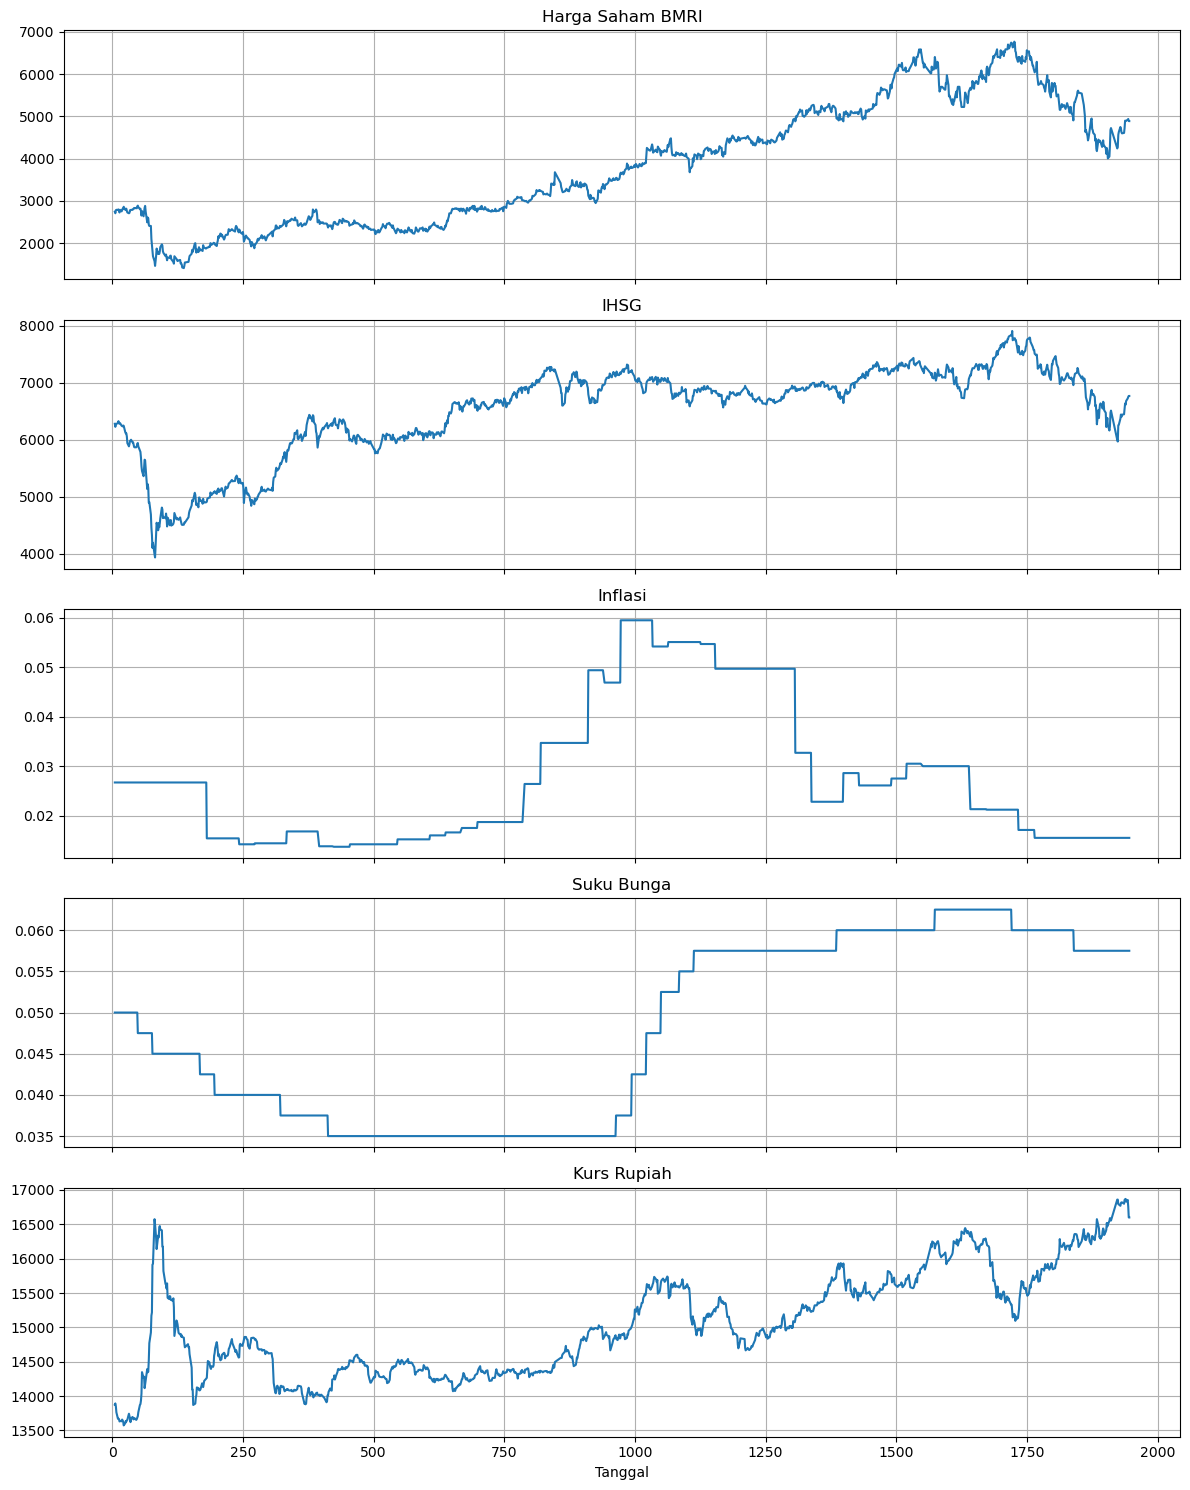

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(12, 15), sharex=True)

cols = ['BMRI', 'IHSG', 'Inflasi', 'Bunga', 'Kurs']
titles = ['Harga Saham BMRI', 'IHSG', 'Inflasi', 'Suku Bunga', 'Kurs Rupiah']

for ax, col, title in zip(axes, cols, titles):
    ax.plot(processed_data.index, processed_data[col])
    ax.set_title(title)
    ax.grid(True)

plt.xlabel('Tanggal')
plt.tight_layout()
plt.show()

Grafik ini menunjukkan bahwa harga saham BMRI dan IHSG cenderung naik meski ada fluktuasi, sementara inflasi dan suku bunga meningkat bersamaan pada periode tertentu sebagai respons kebijakan moneter. Kenaikan suku bunga tampaknya digunakan untuk menekan inflasi, yang juga memengaruhi pergerakan kurs rupiah yang relatif fluktuatif sepanjang waktu.

## Feature Engineering dan Feature Scaling

*Feature engineering* dilakukan dengan menambahkan variabel *lag* dari variabel eksogen, yaitu IHSG, Inflasi, Suku Bunga, dan Kurs. *Lag* yang ditambahkan adalah sampai lima *lag*. Keberadaan *lag* ini digunakan untuk melihat pengaruh dari variabel eksogen di masa lampau pada harga saham BMRI. Selain itu, *feature scaling* diaplikasikan dengan menggunakan metode *robust scaling* untuk memastikan proses *scaling* yang lebih baik. Perhatikan bahwa untuk efisiensi prediksi, maka variabel eksogen pada waktu ke-$t$ tidak akan dimanfaatkan untuk memprediksi harga saham BMRI pada waktu ke-$t$ karena ketersediaan data (data variabel eksogen pada waktu ke-$t$ diketahui secara bersamaan dengan harga saham pada waktu ke-$t$, sehingga inti dari prediksi menjadi hilang).

In [ ]:
SEQ_LEN = 28
LAGS = 5
endog_cols = ['BMRI']
exog_cols = ['IHSG', 'Inflasi', 'Bunga', 'Kurs']

for col in exog_cols:
    for lag in range(1, LAGS + 1):
        processed_data[f'{col}_lag{lag}'] = processed_data[col].shift(lag)
processed_data.dropna(inplace=True)

cols_to_scale = endog_cols + [f'{col}_lag{lag}' for col in exog_cols for lag in range(1, LAGS + 1)]
scaler = RobustScaler()
scaled_data = scaler.fit_transform(processed_data[cols_to_scale])
scaled_df = processed_data[cols_to_scale].copy()
scaled_df.loc[:, :] = scaled_data

X_endog, X_exog, y = create_sequences(scaled_df, SEQ_LEN, endog_cols, exog_cols, LAGS)

split_idx = int(len(X_endog) * 0.8)
X_endog_train, X_endog_test = X_endog[:split_idx], X_endog[split_idx:]
X_exog_train, X_exog_test = X_exog[:split_idx], X_exog[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

## Modeling

Tiga model akan diaplikasikan pada data, yaitu LSTM dengan *multi input*, *hybrid* LSTM-Transformer, dan *hybrind* LSTM-Transformer-TCN.


=== Training dan Evaluasi Model: LSTM Multi Input ===
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 28, 1)]              0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 28, 20)]             0         []                            
                                                                                                  
 concatenate_3 (Concatenate  (None, 28, 21)               0         ['input_7[0][0]',             
 )                                                                   'input_8[0][0]']             
                                                                                                  
 lstm_3 (LSTM)               (None, 6

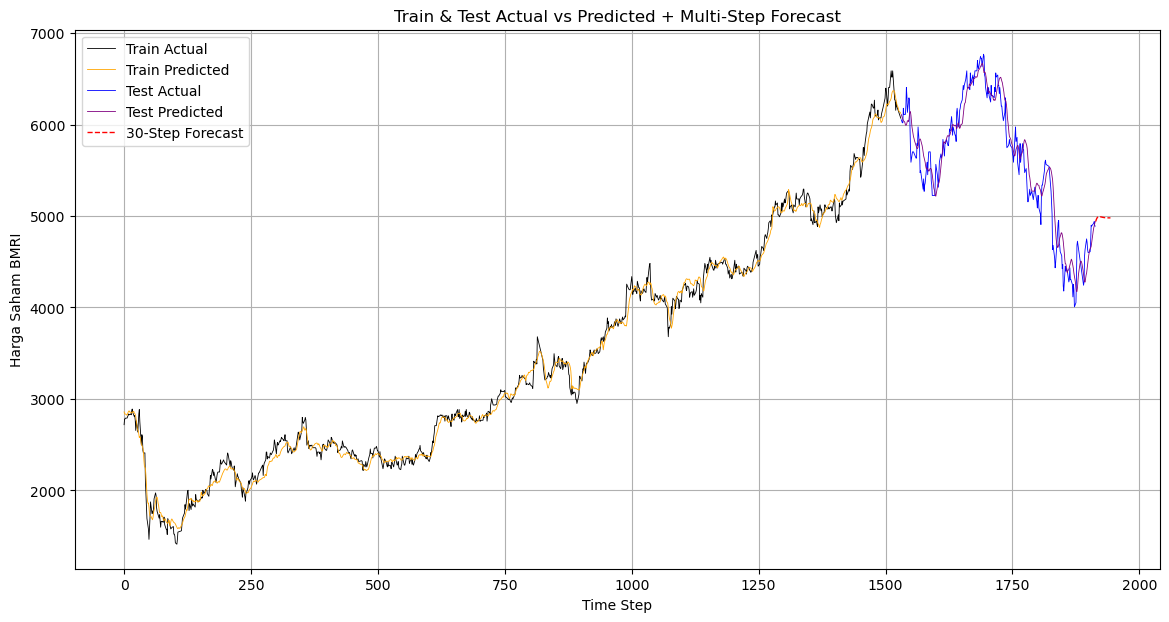


=== Training dan Evaluasi Model: LSTM-Transformer ===
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 28, 20)]             0         []                            
                                                                                                  
 layer_normalization_4 (Lay  (None, 28, 20)               40        ['input_10[0][0]']            
 erNormalization)                                                                                 
                                                                                                  
 multi_head_attention_2 (Mu  (None, 28, 20)               85012     ['layer_normalization_4[0][0]'
 ltiHeadAttention)                                                  , 'layer_normalization_4[0][0]
                                     

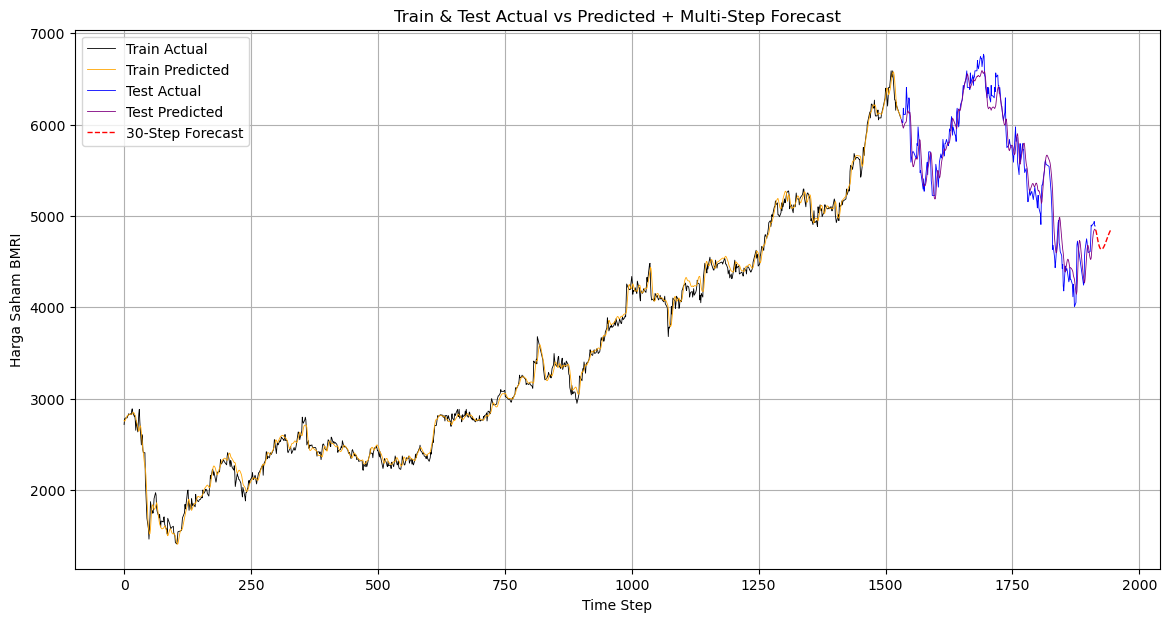


=== Training dan Evaluasi Model: LSTM-Transformer-TCN ===
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 28, 1)]              0         []                            
                                                                                                  
 conv1d_8 (Conv1D)           (None, 28, 32)               128       ['input_11[0][0]']            
                                                                                                  
 spatial_dropout1d_4 (Spati  (None, 28, 32)               0         ['conv1d_8[0][0]']            
 alDropout1D)                                                                                     
                                                                                                  
 conv1d_9 (Conv1D)           (Non

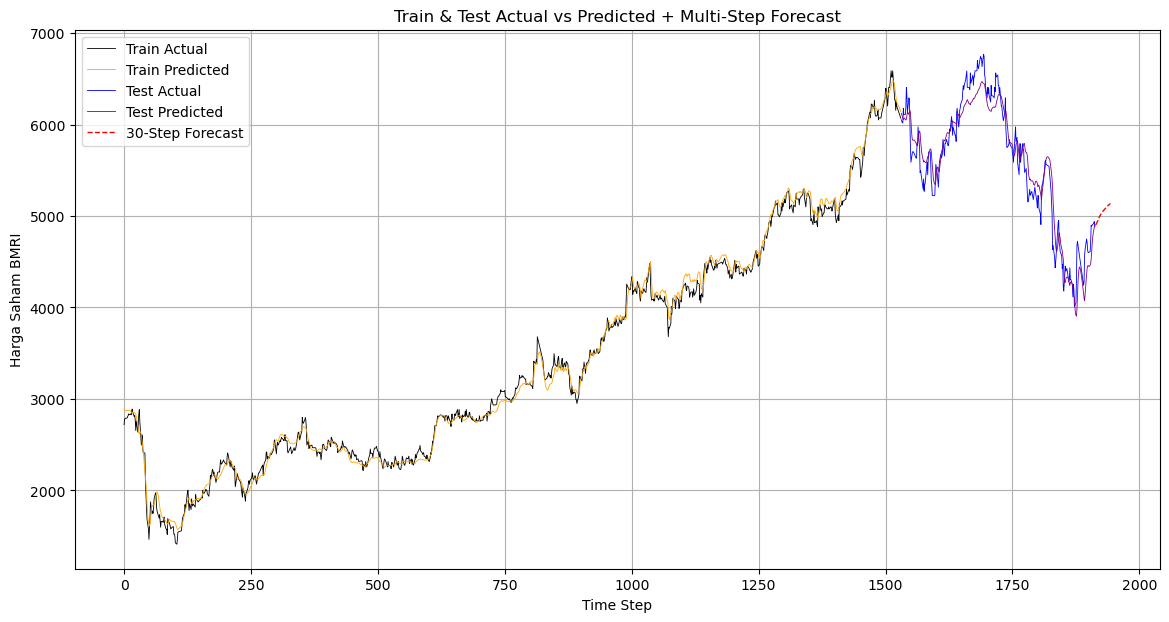

In [ ]:
models_info = {
    "LSTM Multi Input": build_lstm_multi_input(SEQ_LEN, len(endog_cols), X_exog.shape[2]),
    "LSTM-Transformer": build_lstm_transformer(
        seq_len=SEQ_LEN, n_endog=len(endog_cols), n_exog=X_exog.shape[2],
        lstm_units=256, transformer_heads=8, transformer_dim=128, dropout_rate=0.2),
    "LSTM-Transformer-TCN": build_lstm_transformer_tcn(
        seq_len=SEQ_LEN, n_endog=len(endog_cols), n_exog=X_exog.shape[2],
        lstm_units=256, filters=32, kernel_size=3, dilation_rates=[1, 2, 4, 8],
        transformer_heads=8, transformer_dim=128, dropout_rate=0.2)
}

forecast_steps = 30

for name, model in models_info.items():
    print(f"\n=== Training dan Evaluasi Model: {name} ===")
    model.summary()

    history = train_model(model, [X_endog_train, X_exog_train], y_train, [X_endog_test, X_exog_test], y_test)

    # Prediksi train & test
    y_train_pred = model.predict([X_endog_train, X_exog_train])
    y_test_pred = model.predict([X_endog_test, X_exog_test])

    # Inverse transform ke skala asli
    y_train_orig = inverse_transform(scaler, y_train, X_exog_train, exog_cols, LAGS)
    y_train_pred_orig = inverse_transform(scaler, y_train_pred, X_exog_train, exog_cols, LAGS)

    y_test_orig = inverse_transform(scaler, y_test, X_exog_test, exog_cols, LAGS)
    y_test_pred_orig = inverse_transform(scaler, y_test_pred, X_exog_test, exog_cols, LAGS)

    # Evaluasi test set
    print("\nEvaluasi pada test set:")
    metrics = evaluate_forecast(y_test_orig.flatten(), y_test_pred_orig.flatten())

    # Forecast multi-step (30 langkah)
    last_endog_seq = X_endog_test[-1]
    last_exog_seq = X_exog_test[-1]
    forecast_scaled = multi_step_forecast(model, last_endog_seq, last_exog_seq, forecast_steps, LAGS)

    last_exog = last_exog_seq[-1, :]
    forecast_exog_full = np.tile(last_exog, (forecast_steps, 1))

    forecast_full = scaler.inverse_transform(np.hstack([forecast_scaled, forecast_exog_full]))[:, 0]

    # Visualisasi gabungan
    plot_train_val_forecast(
        y_train_orig.flatten(), y_train_pred_orig.flatten(),
        y_test_orig.flatten(), y_test_pred_orig.flatten(),
        forecast_full.flatten(), forecast_steps
    )


Terlihat bahwa ketiga model dapat menangkap pola dengan sangat baik pada data latih dan data uji. Meskipun demikian, peramalan 30 hari ke depan menunjukkan hasil yang berbeda-beda. Model LSTM menunjukkan peramalan konstan, LSTM-Transformer menunjukkan adanya penurunan diikuti oleh kenaikan, sedangkan model LSTM-Transformer-TCN secara optimis menunjukkan adanya kenaikan harga saham. Untuk menentukan model yang akan dijadikan sebagai acuan, akan dibandingkan menggunakan metrik evaluasi berikut.

In [ ]:
# Simpan metrik tiap model di list
metrics_list = []

for name, model in models_info.items():
    print(f"\n=== Training dan Evaluasi Model: {name} ===")
    model.summary()

    history = train_model(model, [X_endog_train, X_exog_train], y_train, [X_endog_test, X_exog_test], y_test)

    y_test_pred = model.predict([X_endog_test, X_exog_test])
    y_test_orig = inverse_transform(scaler, y_test, X_exog_test, exog_cols, LAGS)
    y_test_pred_orig = inverse_transform(scaler, y_test_pred, X_exog_test, exog_cols, LAGS)

    metrics = evaluate_forecast(y_test_orig.flatten(), y_test_pred_orig.flatten())

    # Tambahkan nama model ke dict metrics
    metrics['Model'] = name
    metrics_list.append(metrics)

# Buat DataFrame dari list metrics
df_metrics = pd.DataFrame(metrics_list)

# Urutkan berdasarkan RMSE
df_metrics = df_metrics[['Model', 'MSE', 'RMSE', 'MAE', 'MAPE', 'R2']].sort_values(by='RMSE')
print("\nPerbandingan metrik evaluasi model:")
print(df_metrics)



=== Training dan Evaluasi Model: LSTM Multi Input ===
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 28, 1)]              0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 28, 20)]             0         []                            
                                                                                                  
 concatenate_3 (Concatenate  (None, 28, 21)               0         ['input_7[0][0]',             
 )                                                                   'input_8[0][0]']             
                                                                                                  
 lstm_3 (LSTM)               (None, 6

In [18]:
display(df_metrics)

,Model,MSE,RMSE,MAE,MAPE,R2
1,LSTM-Transformer,24973.092722,158.028772,124.130423,2.339851,0.948974
2,LSTM-Transformer-TCN,38522.359379,196.271137,158.453276,2.903022,0.921290
0,LSTM Multi Input,43705.540458,209.058701,159.976395,3.003778,0.910699


Terlihat bahwa model LSTM-Transformer merupakan model yang paling baik karena memiliki MSE, RMSE, MAE, dan MAPE yang paling rendah, diikuti oleh $R^2$ yang paling tinggi.